In [ ]:
#######################################################################################

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# for visualizing the representation
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from cate_models import *

#######################################################################################

### 2.3 Counterfactual Inference and Domain Adaptation 

In [214]:
## TARNet or CFRMMD depending on alpha ##
class TARNet(nn.Module):
    def __init__(self, df, covariate_cols=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10',
                                           'X11','X12','X13','X14','X15','X16','X17','X18','X19','X20',
                                           'X21','X22','X23','X24','X25'],
                                           treatment_col='T', label_col='Y', ite_label='ITE',alpha=0, lambda_=0,beta=1,
                                           weight_decay=0.01,
                                           lr=0.001, verbose=False, target_reg=False):
        super(TARNet, self).__init__() 
        
        # Data parameters
        self.df = df
        self.covariate_cols = covariate_cols
        self.treatment_col = treatment_col
        self.label_col = label_col
        self.ite_label = ite_label
        self.lr = lr
        self.df, self.test_df = train_test_split(self.df, test_size=0.2, random_state=42)
        
        self.verbose = verbose
        
        # Loss hyperparameters
        self.lambda_ = lambda_
        self.alpha = alpha
        self.target_reg = target_reg
        self.beta = beta
        
        self.u = max(1e-6, min(1 - 1e-6, sum(self.df[self.treatment_col].values) / len(self.df[self.treatment_col].values)))
        print(f'u: {self.u}')
        self.input_dim = len(covariate_cols)
        self.output_dim = 1 # for each arm we predict a single value, Y_hat
        self.hidden_dim = 200
        
        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)
        self.to(self.device)

        # Layers:
        # "CFR is implemented as a feed-forward
        # neural network with 3 fully-connected exponential-linear
        # layers for the representation and 3 for the hypothesis. Layer
        # sizes were 200 for all layers used for Jobs and 200 and 100
        # for the representation and hypothesis used for IHDP.""
        
        self.representation_layers = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            #nn.BatchNorm1d(self.hidden_dim), 
            nn.ELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            #nn.BatchNorm1d(self.hidden_dim), 
            nn.ELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            #nn.BatchNorm1d(self.hidden_dim), 
            nn.ELU(),
        )
        self.control_arm = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            #nn.BatchNorm1d(self.hidden_dim), 
            nn.ELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            #nn.BatchNorm1d(self.hidden_dim), 
            nn.ELU(),
            nn.Linear(self.hidden_dim, self.output_dim)
        )
        self.treatment_arm = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            #nn.BatchNorm1d(self.hidden_dim), 
            nn.ELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            #nn.BatchNorm1d(self.hidden_dim), 
            nn.ELU(),
            nn.Linear(self.hidden_dim, self.output_dim)
            
        )
        
        self.epsilon = nn.Parameter(torch.tensor(1.0))
        
        # The model is trained using Adam's (Kingma & Ba, 2014). 
        # self.optimizer = optim.Adam(
        #                        list(self.representation_layers.parameters())+
        #                        list(self.control_arm.parameters())+
        #                        list(self.treatment_arm.parameters()), lr=self.lr)
        self.optimizer_representation = optim.Adam(list(self.representation_layers.parameters()) + [self.epsilon], lr=lr, weight_decay=weight_decay)
        self.optimizer_control = optim.Adam(list(self.control_arm.parameters()), lr=lr, weight_decay=weight_decay)
        self.optimizer_treatment = optim.Adam(list(self.treatment_arm.parameters()), lr=lr, weight_decay=weight_decay)
    
        # For continuous data we use mean squared loss and for binary data, we'd use log-loss.
        self.prediction_loss = nn.MSELoss()

    def forward(self, X, t):

        representation = self.representation_layers(X)
        control_out = self.control_arm(representation)
        treatment_out = self.treatment_arm(representation)
        y_pred = t * treatment_out + (1 - t) * control_out
        
        return y_pred, representation, control_out, treatment_out
        
    def fit(self, epochs=10, batch_size=64):
        # Set to training mode
        self.representation_layers.train()
        self.treatment_arm.train()
        self.control_arm.train()

        # Get data
        losses = []
        val_losses = []
        print('data:')
        
        X = torch.tensor(self.df[self.covariate_cols].astype(float).values, dtype=torch.float32)
        y = torch.tensor(self.df[self.label_col].values, dtype=torch.float32)
        t = torch.tensor(self.df[self.treatment_col].values, dtype=torch.float32)
        X = X.to(self.device)
        y = y.to(self.device)
        t = t.to(self.device)
        
        print(f'data shapes: {X.shape}, {y.shape}, {t.shape}')
        
        print('starting training')
        for epoch in range(epochs):
            epoch_losses = []

            # Shuffle data
            indices = torch.randperm(len(X))
            X = X[indices]
            y = y[indices]
            t = t[indices]

            batch_size = 64
            # Batch data
            for i in range(0, len(X), batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                t_batch = t[i:i + batch_size]

               
                # Zero gradients
                #self.optimizer.zero_grad()
                self.optimizer_representation.zero_grad()
                self.optimizer_control.zero_grad()
                self.optimizer_treatment.zero_grad()

                y_pred, representation, _, _ = self.forward(X_batch, t_batch)
                

                # Calculate weights
                weights = (t_batch / (2 * self.u)) + ((1 - t_batch) / (2 * (1 - self.u)))
                # print(weights)
                
                # Calculate prediction loss
                loss_pred = torch.mean(weights * self.prediction_loss(y_pred, y_batch))
                #print(f'loss_prediction: {loss}')
                #loss = loss_pred.clone()
                
                control_condition = (t_batch==0)
                
                representation_control = representation[control_condition]
                representation_treatment = representation[~control_condition]

                #loss_pred = loss_y0 + loss_y1  # Prediction loss

                # Squared Linear MMD = IPM loss example -- idk what they even use in the paper
                loss_ipm = self.alpha * torch.norm(representation_control.mean() - representation_treatment.mean(), p=2) ** 2 
                #loss = loss.clone() + loss_ipm
                
                # Regularizing loss
                # Ignore regularization for now
                #regularizing_term = self.lambda_ * torch.norm(self.weights, p=2) 
                #loss += regularizing_term
                
                if self.target_reg:
                    target = y_batch - y_pred + self.epsilon*(t_batch/ self.u + (1-t_batch)/(1-self.u))
                    loss_target = self.beta * torch.mean(target)
                    loss_pred += loss_target

                # Backpropagate **only** prediction loss (updates all optimizers)
                loss_pred.backward(retain_graph=True)
                #self.optimizer_representation.step()
                self.optimizer_control.step()
                self.optimizer_treatment.step()

                # Backpropagate **only** IPM loss (updates only representation layers)
                #self.optimizer_representation.zero_grad()  # Zero out before IPM step
                #loss = loss_pred.clone() + loss_ipm
                loss_ipm.backward()
                self.optimizer_representation.step()
                
                # Backpropagate both prediction loss (through all layers) and IPM loss (through representation layers)
                # loss.backward()  
                # self.optimizer.step()
                
                loss = loss_pred + loss_ipm
                
                epoch_losses.append(loss.item())
            
            avg_loss = sum(epoch_losses) / len(epoch_losses)
            
            losses.append(avg_loss)

            if epoch % 10 == 0 and self.verbose:
                print('')
                print(f'Epoch: {epoch}, Loss: {loss_pred.item()}')
                
            
            # Calculate test set loss
            test_X = torch.tensor(self.test_df[self.covariate_cols].astype(float).values, dtype=torch.float32).to(self.device)
            test_y = torch.tensor(self.test_df[self.label_col].values, dtype=torch.float32).to(self.device)
            test_t = torch.tensor(self.test_df[self.treatment_col].values, dtype=torch.float32).to(self.device)

            self.eval()
            with torch.no_grad():
                test_y_pred, _, _, _ = self.forward(test_X, test_t)
                test_loss = self.prediction_loss(test_y_pred, test_y).item()
                val_losses.append(test_loss)
                print(f'Test set loss: {test_loss}')
                
        print('done training')
        

        return losses, val_losses
        
           
    def predict_train(self, use_ite=False):
        X = torch.tensor(self.df[self.covariate_cols].astype(float).values, dtype=torch.float32)
        y = torch.tensor(self.df[self.label_col].values, dtype=torch.float32)
        t = torch.tensor(self.df[self.treatment_col].values, dtype=torch.float32)
        X = X.to(self.device)
        y = y.to(self.device)
        t = t.to(self.device)
        if use_ite:
            ite = torch.tensor(self.df[self.ite_label].astype(float).values, dtype=torch.float32)
        else:
            ite = None
        self.eval()  # Set model to evaluation mode
        with torch.no_grad():  # No gradients needed for prediction
            return self.forward(X,t), X, y, t, ite
    
    def predict_test(self, use_ite=False):
        X = torch.tensor(self.test_df[self.covariate_cols].astype(float).values, dtype=torch.float32)
        y = torch.tensor(self.test_df[self.label_col].values, dtype=torch.float32)
        t = torch.tensor(self.test_df[self.treatment_col].values, dtype=torch.float32)
        X = X.to(self.device)
        y = y.to(self.device)
        t = t.to(self.device)
        if use_ite:
            ite = torch.tensor(self.test_df[self.ite_label].astype(float).values, dtype=torch.float32)
        else:
            ite = None
        self.eval()  # Set model to evaluation mode
        with torch.no_grad():  # No gradients needed for prediction
            return self.forward(X,t), X, y, t, ite
    
    # plot the t-sne
    def plot_representation_space(self, representation=None, t=None, n_components=2):
        """Plot the representation space"""
        
        if representation is None:
            representation = torch.tensor(self.df[self.covariate_cols].astype(float).values, dtype=torch.float32)
            t = torch.tensor(self.df[self.treatment_col].values, dtype=torch.float32)
        # Index on what is control versus treatment
        representation_control = representation[t == 0]
        representation_treatment = representation[t == 1]

        # Run separate t-SNE on control and treatment representations
        tsne_control = TSNE(n_components=n_components, random_state=42)
        X_tsne_control = tsne_control.fit_transform(representation_control.detach().numpy())
        
        tsne_treatment = TSNE(n_components=n_components, random_state=42)
        X_tsne_treatment = tsne_treatment.fit_transform(representation_treatment.detach().numpy())

        # Plot t-SNE
        plt.scatter(X_tsne_control[:, 0], X_tsne_control[:, 1], color='blue', label='Control')
        plt.scatter(X_tsne_treatment[:, 0], X_tsne_treatment[:, 1], color='red', label='Treatment')
        plt.title("t-SNE Visualization")
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.legend()
        plt.show()
    
    def compute_PEHE_ATE_metrics(self, control_output, treatment_output, t, ite=None):
        """Compute comparison metrics"""
        ite_pred = treatment_output - control_output 
        if ite is not None:
            ite_true = ite 
        else:
            ite_true = torch.where(t == 1, y, -y)
        #print(ite_pred, ite_true)
        pehe = torch.mean((ite_pred - ite_true) ** 2)
        #print(pehe)
    
        ate_pred = torch.mean(ite_pred)  
        ate_true = torch.mean(ite_true)  
        ate_error = torch.abs(ate_pred - ate_true)
        
        return pehe.item(), ate_error.item(), ite_pred, ate_pred 

In [100]:
IHDP_data = pd.read_csv("ihdp_project2.csv.gz")

In [43]:
IHDP_data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X24,X25,T,Y,Y_cf,Y1,Y0,ITE,ps,CATE
0,0,0.316588,0.596582,-0.360898,-0.879606,0.371086,-1.189018,1.0,0.0,1.0,...,0.0,0.0,1,6.221720,6.221720,6.221720,1.938568,4.283151,0.096134,4.651689
1,1,0.186891,0.196818,-0.360898,0.161703,-1.379396,0.467138,0.0,0.0,1.0,...,0.0,1.0,0,3.899687,5.741144,5.741144,3.899687,1.841458,0.346382,4.029681
2,2,0.532750,0.196818,-0.360898,-0.879606,1.934016,-1.354634,0.0,0.0,0.0,...,0.0,0.0,0,2.405894,6.709281,6.709281,2.405894,4.303386,0.071968,4.644078
3,3,0.294972,-0.202946,-0.360898,-0.879606,0.121017,-1.023402,0.0,0.0,1.0,...,0.0,1.0,0,1.469327,6.868562,6.868562,1.469327,5.399234,0.294487,4.635409
4,4,-0.548057,-0.202946,-0.360898,-0.879606,0.183534,-0.360940,0.0,1.0,0.0,...,0.0,0.0,0,0.558776,6.471721,6.471721,0.558776,5.912945,0.138918,4.509761


In [189]:
tarnet_model = TARNet(df=IHDP_data, alpha = 1, target_reg=True)
tarnet_model.fit(epochs=20)

u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training


[21.16135528087616,
 4.945757460594177,
 3.415143835544586,
 3.144415283203125,
 3.029424047470093,
 2.930993342399597,
 2.9251203775405883,
 3.014260697364807,
 2.9409242153167723,
 2.8844500303268434,
 2.818005323410034,
 2.8120114326477053,
 2.7839060068130492,
 2.833407688140869,
 2.7490846633911135,
 2.6919788837432863,
 2.718809390068054,
 2.706429672241211,
 2.702699971199036,
 2.7133095264434814]

In [196]:
# TARNET grid search
from itertools import product

alpha_values = np.linspace(0, 100, 10)  
weight_decay_values = [0, 1e-5, 1e-4, 1e-3, 1e-2] 
learning_rate_values = [1e-4, 1e-3, 1e-2]  

losses = []

# Perform grid search
for alpha, weight_decay, learning_rate in product(alpha_values, weight_decay_values, learning_rate_values):
    tarnet_model = TARNet(df=IHDP_data, alpha=alpha, lr=learning_rate, weight_decay=weight_decay)  

    # Train model
    loss_curve, test_loss = tarnet_model.fit(epochs=10)

    # Evaluate on validation set
    output, X, y, t, ite = tarnet_model.predict_test(use_ite=True)
    PEHE_val, ATE_val, _, _ = tarnet_model.compute_PEHE_ATE_metrics(output[2], output[3], t, ite)

    # Evaluate on training set
    output, X, y, t, ite = tarnet_model.predict_train(use_ite=True)
    PEHE_train, ATE_train, _, _ = tarnet_model.compute_PEHE_ATE_metrics(output[2], output[3], t, ite)

    print(f"Alpha: {alpha}, LR: {learning_rate}, WD: {weight_decay}, PEHE: {np.sqrt(PEHE_val)}, ATE: {ATE_val}, test loss {test_loss}")

    losses.append(pd.DataFrame({
        'alpha': [alpha],
        'learning_rate': [learning_rate],
        'weight_decay': [weight_decay],
        'PEHE_train': [PEHE_train],
        'PEHE_val': [PEHE_val],
        'ATE_train': [ATE_train],
        'ATE_val': [ATE_val],
        'test_pred_loss': [test_loss]
    }))


data_loss_curves = pd.concat(losses, ignore_index=True)


u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
Test set loss: 1.4435852766036987
Alpha: 0.0, LR: 0.0001, WD: 0, PEHE: 1.6023746571194155, ATE: 0.26496315002441406, test loss 1.4435852766036987
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3012627363204956
Alpha: 0.0, LR: 0.001, WD: 0, PEHE: 1.614505921835862, ATE: 0.4429154396057129, test loss 1.3012627363204956
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2749632596969604
Alpha: 0.0, LR: 0.01, WD: 0, PEHE: 1.670854060677874, ATE: 0.622016429901123, test loss 1.2749632596969604
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4123042821884155
Alpha: 0.0, LR: 0.0001, WD: 1e-05, PEHE: 1.637635841267938, ATE: 0.4250450134277344, test loss 1.4123042821884155
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3239058256149292
Alpha: 0.0, LR: 0.001, WD: 1e-05, PEHE: 1.6392239355656677, ATE: 0.5208702087402344, test loss 1.3239058256149292
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2736093997955322
Alpha: 0.0, LR: 0.01, WD: 1e-05, PEHE: 1.654248810016953, ATE: 0.5762553215026855, test loss 1.2736093997955322
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4414196014404297
Alpha: 0.0, LR: 0.0001, WD: 0.0001, PEHE: 1.584327820445996, ATE: 0.1777973175048828, test loss 1.4414196014404297
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.31083083152771
Alpha: 0.0, LR: 0.001, WD: 0.0001, PEHE: 1.648704326422156, ATE: 0.5535202026367188, test loss 1.31083083152771
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3034411668777466
Alpha: 0.0, LR: 0.01, WD: 0.0001, PEHE: 1.8329537677876115, ATE: 0.9749860763549805, test loss 1.3034411668777466
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4187871217727661
Alpha: 0.0, LR: 0.0001, WD: 0.001, PEHE: 1.5820168576939861, ATE: 0.2088150978088379, test loss 1.4187871217727661
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3097691535949707
Alpha: 0.0, LR: 0.001, WD: 0.001, PEHE: 1.5960282142841384, ATE: 0.36732006072998047, test loss 1.3097691535949707
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.399922251701355
Alpha: 0.0, LR: 0.01, WD: 0.001, PEHE: 1.5502689774226306, ATE: 0.0002498626708984375, test loss 1.399922251701355
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4478814601898193
Alpha: 0.0, LR: 0.0001, WD: 0.01, PEHE: 1.5957463794388085, ATE: 0.23172760009765625, test loss 1.4478814601898193
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3359383344650269
Alpha: 0.0, LR: 0.001, WD: 0.01, PEHE: 1.5785082361189509, ATE: 0.28433656692504883, test loss 1.3359383344650269
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.326275110244751
Alpha: 0.0, LR: 0.01, WD: 0.01, PEHE: 1.6312574802972573, ATE: 0.5067586898803711, test loss 1.326275110244751
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4210028648376465
Alpha: 11.11111111111111, LR: 0.0001, WD: 0, PEHE: 1.5992540796325372, ATE: 0.278475284576416, test loss 1.4210028648376465
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3782130479812622
Alpha: 11.11111111111111, LR: 0.001, WD: 0, PEHE: 1.557209365694272, ATE: 0.11638832092285156, test loss 1.3782130479812622
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.5032076835632324
Alpha: 11.11111111111111, LR: 0.01, WD: 0, PEHE: 1.5678893414638055, ATE: 0.1888442039489746, test loss 1.5032076835632324
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4413180351257324
Alpha: 11.11111111111111, LR: 0.0001, WD: 1e-05, PEHE: 1.5936601650874314, ATE: 0.23263025283813477, test loss 1.4413180351257324
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3125320672988892
Alpha: 11.11111111111111, LR: 0.001, WD: 1e-05, PEHE: 1.6030886194216962, ATE: 0.39449024200439453, test loss 1.3125320672988892
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.272498607635498
Alpha: 11.11111111111111, LR: 0.01, WD: 1e-05, PEHE: 1.7124765519813157, ATE: 0.7263393402099609, test loss 1.272498607635498
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4378873109817505
Alpha: 11.11111111111111, LR: 0.0001, WD: 0.0001, PEHE: 1.5875784366484027, ATE: 0.2048201560974121, test loss 1.4378873109817505
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.293360948562622
Alpha: 11.11111111111111, LR: 0.001, WD: 0.0001, PEHE: 1.6638419851415505, ATE: 0.5925383567810059, test loss 1.293360948562622
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.398114800453186
Alpha: 11.11111111111111, LR: 0.01, WD: 0.0001, PEHE: 1.5529969958972063, ATE: 0.0342864990234375, test loss 1.398114800453186
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4226281642913818
Alpha: 11.11111111111111, LR: 0.0001, WD: 0.001, PEHE: 1.5901212332949075, ATE: 0.22836828231811523, test loss 1.4226281642913818
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3000328540802002
Alpha: 11.11111111111111, LR: 0.001, WD: 0.001, PEHE: 1.6528990333308282, ATE: 0.5637407302856445, test loss 1.3000328540802002
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3143012523651123
Alpha: 11.11111111111111, LR: 0.01, WD: 0.001, PEHE: 1.6030925606165267, ATE: 0.40608882904052734, test loss 1.3143012523651123
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4171913862228394
Alpha: 11.11111111111111, LR: 0.0001, WD: 0.01, PEHE: 1.595711790922766, ATE: 0.2692451477050781, test loss 1.4171913862228394
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3055918216705322
Alpha: 11.11111111111111, LR: 0.001, WD: 0.01, PEHE: 1.6206130452566567, ATE: 0.4590282440185547, test loss 1.3055918216705322
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3062533140182495
Alpha: 11.11111111111111, LR: 0.01, WD: 0.01, PEHE: 1.6849835317469133, ATE: 0.6563143730163574, test loss 1.3062533140182495
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4183777570724487
Alpha: 22.22222222222222, LR: 0.0001, WD: 0, PEHE: 1.5934010291914873, ATE: 0.25115251541137695, test loss 1.4183777570724487
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.331774115562439
Alpha: 22.22222222222222, LR: 0.001, WD: 0, PEHE: 1.5889047760083956, ATE: 0.3361802101135254, test loss 1.331774115562439
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4228976964950562
Alpha: 22.22222222222222, LR: 0.01, WD: 0, PEHE: 1.7619695040935621, ATE: 0.804175853729248, test loss 1.4228976964950562
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4081058502197266
Alpha: 22.22222222222222, LR: 0.0001, WD: 1e-05, PEHE: 1.5828036459612074, ATE: 0.22100162506103516, test loss 1.4081058502197266
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.334883689880371
Alpha: 22.22222222222222, LR: 0.001, WD: 1e-05, PEHE: 1.6194108799589042, ATE: 0.4576683044433594, test loss 1.334883689880371
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3170692920684814
Alpha: 22.22222222222222, LR: 0.01, WD: 1e-05, PEHE: 1.7822220810089204, ATE: 0.8789820671081543, test loss 1.3170692920684814
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4334009885787964
Alpha: 22.22222222222222, LR: 0.0001, WD: 0.0001, PEHE: 1.5910790445531722, ATE: 0.23400115966796875, test loss 1.4334009885787964
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3005352020263672
Alpha: 22.22222222222222, LR: 0.001, WD: 0.0001, PEHE: 1.632650705014689, ATE: 0.5023994445800781, test loss 1.3005352020263672
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2896029949188232
Alpha: 22.22222222222222, LR: 0.01, WD: 0.0001, PEHE: 1.76720931278329, ATE: 0.8487210273742676, test loss 1.2896029949188232
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4451855421066284
Alpha: 22.22222222222222, LR: 0.0001, WD: 0.001, PEHE: 1.601651817250295, ATE: 0.25603580474853516, test loss 1.4451855421066284
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3217501640319824
Alpha: 22.22222222222222, LR: 0.001, WD: 0.001, PEHE: 1.6156161870660717, ATE: 0.44140100479125977, test loss 1.3217501640319824
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.271868109703064
Alpha: 22.22222222222222, LR: 0.01, WD: 0.001, PEHE: 1.6820735573486503, ATE: 0.6521921157836914, test loss 1.271868109703064
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4230822324752808
Alpha: 22.22222222222222, LR: 0.0001, WD: 0.01, PEHE: 1.5783323397259, ATE: 0.18871164321899414, test loss 1.4230822324752808
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.337394118309021
Alpha: 22.22222222222222, LR: 0.001, WD: 0.01, PEHE: 1.5738036410618406, ATE: 0.24756813049316406, test loss 1.337394118309021
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2733789682388306
Alpha: 22.22222222222222, LR: 0.01, WD: 0.01, PEHE: 1.725687072588063, ATE: 0.7562589645385742, test loss 1.2733789682388306
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4670206308364868
Alpha: 33.33333333333333, LR: 0.0001, WD: 0, PEHE: 1.5766765632614508, ATE: 0.11887168884277344, test loss 1.4670206308364868
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3019901514053345
Alpha: 33.33333333333333, LR: 0.001, WD: 0, PEHE: 1.633638601905122, ATE: 0.5055928230285645, test loss 1.3019901514053345
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2902886867523193
Alpha: 33.33333333333333, LR: 0.01, WD: 0, PEHE: 1.7842820445632415, ATE: 0.8834881782531738, test loss 1.2902886867523193
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4100724458694458
Alpha: 33.33333333333333, LR: 0.0001, WD: 1e-05, PEHE: 1.6104150022799966, ATE: 0.34053564071655273, test loss 1.4100724458694458
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3163784742355347
Alpha: 33.33333333333333, LR: 0.001, WD: 1e-05, PEHE: 1.5964090193699905, ATE: 0.37041807174682617, test loss 1.3163784742355347
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.270885705947876
Alpha: 33.33333333333333, LR: 0.01, WD: 1e-05, PEHE: 1.6970242766586598, ATE: 0.6898231506347656, test loss 1.270885705947876
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4446552991867065
Alpha: 33.33333333333333, LR: 0.0001, WD: 0.0001, PEHE: 1.6110919571245843, ATE: 0.3013424873352051, test loss 1.4446552991867065
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2938711643218994
Alpha: 33.33333333333333, LR: 0.001, WD: 0.0001, PEHE: 1.6736566195317781, ATE: 0.6223354339599609, test loss 1.2938711643218994
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3052363395690918
Alpha: 33.33333333333333, LR: 0.01, WD: 0.0001, PEHE: 1.701992883539619, ATE: 0.6952090263366699, test loss 1.3052363395690918
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.409331202507019
Alpha: 33.33333333333333, LR: 0.0001, WD: 0.001, PEHE: 1.5888783666103727, ATE: 0.24491262435913086, test loss 1.409331202507019
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3202489614486694
Alpha: 33.33333333333333, LR: 0.001, WD: 0.001, PEHE: 1.603060658968842, ATE: 0.39385080337524414, test loss 1.3202489614486694
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.387395977973938
Alpha: 33.33333333333333, LR: 0.01, WD: 0.001, PEHE: 1.610825338815795, ATE: 0.43805408477783203, test loss 1.387395977973938
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4256571531295776
Alpha: 33.33333333333333, LR: 0.0001, WD: 0.01, PEHE: 1.5881786577872476, ATE: 0.2200922966003418, test loss 1.4256571531295776
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3286044597625732
Alpha: 33.33333333333333, LR: 0.001, WD: 0.01, PEHE: 1.6006038122476587, ATE: 0.3840007781982422, test loss 1.3286044597625732
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3933969736099243
Alpha: 33.33333333333333, LR: 0.01, WD: 0.01, PEHE: 1.5693106420789236, ATE: 0.2447037696838379, test loss 1.3933969736099243
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.413692831993103
Alpha: 44.44444444444444, LR: 0.0001, WD: 0, PEHE: 1.5893994209552504, ATE: 0.2425251007080078, test loss 1.413692831993103
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3057869672775269
Alpha: 44.44444444444444, LR: 0.001, WD: 0, PEHE: 1.6593907644668866, ATE: 0.5809130668640137, test loss 1.3057869672775269
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2769910097122192
Alpha: 44.44444444444444, LR: 0.01, WD: 0, PEHE: 1.6506699184674314, ATE: 0.5611515045166016, test loss 1.2769910097122192
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.443214774131775
Alpha: 44.44444444444444, LR: 0.0001, WD: 1e-05, PEHE: 1.5937320483823545, ATE: 0.23120355606079102, test loss 1.443214774131775
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3083597421646118
Alpha: 44.44444444444444, LR: 0.001, WD: 1e-05, PEHE: 1.6307139074813148, ATE: 0.496335506439209, test loss 1.3083597421646118
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3158864974975586
Alpha: 44.44444444444444, LR: 0.01, WD: 1e-05, PEHE: 1.5765395556955135, ATE: 0.28533077239990234, test loss 1.3158864974975586
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.452782154083252
Alpha: 44.44444444444444, LR: 0.0001, WD: 0.0001, PEHE: 1.5990294731625432, ATE: 0.23927974700927734, test loss 1.452782154083252
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2897707223892212
Alpha: 44.44444444444444, LR: 0.001, WD: 0.0001, PEHE: 1.6586436842284962, ATE: 0.5843725204467773, test loss 1.2897707223892212
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3086497783660889
Alpha: 44.44444444444444, LR: 0.01, WD: 0.0001, PEHE: 1.6167053388446906, ATE: 0.4581012725830078, test loss 1.3086497783660889
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4097312688827515
Alpha: 44.44444444444444, LR: 0.0001, WD: 0.001, PEHE: 1.6145522165889101, ATE: 0.3467411994934082, test loss 1.4097312688827515
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3275890350341797
Alpha: 44.44444444444444, LR: 0.001, WD: 0.001, PEHE: 1.5897770148290176, ATE: 0.3271913528442383, test loss 1.3275890350341797
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3128793239593506
Alpha: 44.44444444444444, LR: 0.01, WD: 0.001, PEHE: 1.5903414760235355, ATE: 0.35402917861938477, test loss 1.3128793239593506
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4579473733901978
Alpha: 44.44444444444444, LR: 0.0001, WD: 0.01, PEHE: 1.5937663058774472, ATE: 0.2279067039489746, test loss 1.4579473733901978
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.326339602470398
Alpha: 44.44444444444444, LR: 0.001, WD: 0.01, PEHE: 1.633254798960354, ATE: 0.5037679672241211, test loss 1.326339602470398
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3015341758728027
Alpha: 44.44444444444444, LR: 0.01, WD: 0.01, PEHE: 1.5895860917786961, ATE: 0.351102352142334, test loss 1.3015341758728027
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4532864093780518
Alpha: 55.55555555555556, LR: 0.0001, WD: 0, PEHE: 1.5928212619994788, ATE: 0.21069574356079102, test loss 1.4532864093780518
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3101969957351685
Alpha: 55.55555555555556, LR: 0.001, WD: 0, PEHE: 1.6195636928196084, ATE: 0.45652246475219727, test loss 1.3101969957351685
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3210011720657349
Alpha: 55.55555555555556, LR: 0.01, WD: 0, PEHE: 1.5887983104404866, ATE: 0.34601783752441406, test loss 1.3210011720657349
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.398567795753479
Alpha: 55.55555555555556, LR: 0.0001, WD: 1e-05, PEHE: 1.6040606112741231, ATE: 0.3186030387878418, test loss 1.398567795753479
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3095378875732422
Alpha: 55.55555555555556, LR: 0.001, WD: 1e-05, PEHE: 1.611974524109728, ATE: 0.42738771438598633, test loss 1.3095378875732422
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2866588830947876
Alpha: 55.55555555555556, LR: 0.01, WD: 1e-05, PEHE: 1.6478272524310218, ATE: 0.5422663688659668, test loss 1.2866588830947876
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3810808658599854
Alpha: 55.55555555555556, LR: 0.0001, WD: 0.0001, PEHE: 1.5911282685637589, ATE: 0.28482484817504883, test loss 1.3810808658599854
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.311165452003479
Alpha: 55.55555555555556, LR: 0.001, WD: 0.0001, PEHE: 1.592542452643087, ATE: 0.35559988021850586, test loss 1.311165452003479
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3069205284118652
Alpha: 55.55555555555556, LR: 0.01, WD: 0.0001, PEHE: 1.7504991092107578, ATE: 0.8103928565979004, test loss 1.3069205284118652
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4091111421585083
Alpha: 55.55555555555556, LR: 0.0001, WD: 0.001, PEHE: 1.5977223576157238, ATE: 0.28766822814941406, test loss 1.4091111421585083
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.300238013267517
Alpha: 55.55555555555556, LR: 0.001, WD: 0.001, PEHE: 1.6185901106296268, ATE: 0.4552440643310547, test loss 1.300238013267517
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2947168350219727
Alpha: 55.55555555555556, LR: 0.01, WD: 0.001, PEHE: 1.6444375924377195, ATE: 0.5359883308410645, test loss 1.2947168350219727
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.402382254600525
Alpha: 55.55555555555556, LR: 0.0001, WD: 0.01, PEHE: 1.604640775035565, ATE: 0.3229846954345703, test loss 1.402382254600525
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3088295459747314
Alpha: 55.55555555555556, LR: 0.001, WD: 0.01, PEHE: 1.6226037036687504, ATE: 0.46601343154907227, test loss 1.3088295459747314
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.459115743637085
Alpha: 55.55555555555556, LR: 0.01, WD: 0.01, PEHE: 1.7115938504091865, ATE: 0.7247934341430664, test loss 1.459115743637085
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4078718423843384
Alpha: 66.66666666666666, LR: 0.0001, WD: 0, PEHE: 1.6190836382179785, ATE: 0.37160825729370117, test loss 1.4078718423843384
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3124010562896729
Alpha: 66.66666666666666, LR: 0.001, WD: 0, PEHE: 1.6172604014601302, ATE: 0.4468693733215332, test loss 1.3124010562896729
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3114402294158936
Alpha: 66.66666666666666, LR: 0.01, WD: 0, PEHE: 1.5791254177426621, ATE: 0.29301023483276367, test loss 1.3114402294158936
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4663265943527222
Alpha: 66.66666666666666, LR: 0.0001, WD: 1e-05, PEHE: 1.6021601608500364, ATE: 0.2508258819580078, test loss 1.4663265943527222
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3287792205810547
Alpha: 66.66666666666666, LR: 0.001, WD: 1e-05, PEHE: 1.6657973724549697, ATE: 0.5944328308105469, test loss 1.3287792205810547
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3175585269927979
Alpha: 66.66666666666666, LR: 0.01, WD: 1e-05, PEHE: 1.573655020443588, ATE: 0.25660133361816406, test loss 1.3175585269927979
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4195483922958374
Alpha: 66.66666666666666, LR: 0.0001, WD: 0.0001, PEHE: 1.6297084379085518, ATE: 0.40761709213256836, test loss 1.4195483922958374
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.323434829711914
Alpha: 66.66666666666666, LR: 0.001, WD: 0.0001, PEHE: 1.5908345502259582, ATE: 0.33495664596557617, test loss 1.323434829711914
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3161444664001465
Alpha: 66.66666666666666, LR: 0.01, WD: 0.0001, PEHE: 1.5753362962665587, ATE: 0.27452850341796875, test loss 1.3161444664001465
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.400177240371704
Alpha: 66.66666666666666, LR: 0.0001, WD: 0.001, PEHE: 1.5896565095082793, ATE: 0.2584691047668457, test loss 1.400177240371704
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2967596054077148
Alpha: 66.66666666666666, LR: 0.001, WD: 0.001, PEHE: 1.6418281140147521, ATE: 0.531611442565918, test loss 1.2967596054077148
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2850226163864136
Alpha: 66.66666666666666, LR: 0.01, WD: 0.001, PEHE: 1.6642128603348143, ATE: 0.6040902137756348, test loss 1.2850226163864136
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4152717590332031
Alpha: 66.66666666666666, LR: 0.0001, WD: 0.01, PEHE: 1.6154654359511402, ATE: 0.35120344161987305, test loss 1.4152717590332031
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3122279644012451
Alpha: 66.66666666666666, LR: 0.001, WD: 0.01, PEHE: 1.6307232645765202, ATE: 0.4901161193847656, test loss 1.3122279644012451
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3328102827072144
Alpha: 66.66666666666666, LR: 0.01, WD: 0.01, PEHE: 1.5975541732748382, ATE: 0.3860511779785156, test loss 1.3328102827072144
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4358288049697876
Alpha: 77.77777777777777, LR: 0.0001, WD: 0, PEHE: 1.6064810056112617, ATE: 0.29335594177246094, test loss 1.4358288049697876
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3348267078399658
Alpha: 77.77777777777777, LR: 0.001, WD: 0, PEHE: 1.5806369241345402, ATE: 0.294217586517334, test loss 1.3348267078399658
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.476166844367981
Alpha: 77.77777777777777, LR: 0.01, WD: 0, PEHE: 1.6166233423988918, ATE: 0.4573216438293457, test loss 1.476166844367981
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4377377033233643
Alpha: 77.77777777777777, LR: 0.0001, WD: 1e-05, PEHE: 1.5737050167135886, ATE: 0.1311030387878418, test loss 1.4377377033233643
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3242285251617432
Alpha: 77.77777777777777, LR: 0.001, WD: 1e-05, PEHE: 1.66120866515988, ATE: 0.5841341018676758, test loss 1.3242285251617432
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4063297510147095
Alpha: 77.77777777777777, LR: 0.01, WD: 1e-05, PEHE: 1.7678260924349636, ATE: 0.7252521514892578, test loss 1.4063297510147095
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.465321660041809
Alpha: 77.77777777777777, LR: 0.0001, WD: 0.0001, PEHE: 1.6028131579514713, ATE: 0.25725555419921875, test loss 1.465321660041809
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3188904523849487
Alpha: 77.77777777777777, LR: 0.001, WD: 0.0001, PEHE: 1.5929796189502838, ATE: 0.35282421112060547, test loss 1.3188904523849487
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3068537712097168
Alpha: 77.77777777777777, LR: 0.01, WD: 0.0001, PEHE: 1.6268781665327139, ATE: 0.4910268783569336, test loss 1.3068537712097168
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.448288083076477
Alpha: 77.77777777777777, LR: 0.0001, WD: 0.001, PEHE: 1.587009011582555, ATE: 0.18093395233154297, test loss 1.448288083076477
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.299133539199829
Alpha: 77.77777777777777, LR: 0.001, WD: 0.001, PEHE: 1.6273074273768313, ATE: 0.4841938018798828, test loss 1.299133539199829
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.381379246711731
Alpha: 77.77777777777777, LR: 0.01, WD: 0.001, PEHE: 1.5692313348724531, ATE: 0.22372865676879883, test loss 1.381379246711731
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4389925003051758
Alpha: 77.77777777777777, LR: 0.0001, WD: 0.01, PEHE: 1.587734012927507, ATE: 0.2089829444885254, test loss 1.4389925003051758
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2931984663009644
Alpha: 77.77777777777777, LR: 0.001, WD: 0.01, PEHE: 1.6671169705832183, ATE: 0.603912353515625, test loss 1.2931984663009644
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.284790277481079
Alpha: 77.77777777777777, LR: 0.01, WD: 0.01, PEHE: 1.6175167467291016, ATE: 0.46202945709228516, test loss 1.284790277481079
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4472987651824951
Alpha: 88.88888888888889, LR: 0.0001, WD: 0, PEHE: 1.601029916925776, ATE: 0.25298547744750977, test loss 1.4472987651824951
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3167643547058105
Alpha: 88.88888888888889, LR: 0.001, WD: 0, PEHE: 1.5996543868628836, ATE: 0.3747286796569824, test loss 1.3167643547058105
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3021162748336792
Alpha: 88.88888888888889, LR: 0.01, WD: 0, PEHE: 1.5974088817752143, ATE: 0.3847637176513672, test loss 1.3021162748336792
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4471447467803955
Alpha: 88.88888888888889, LR: 0.0001, WD: 1e-05, PEHE: 1.587082322810459, ATE: 0.1845240592956543, test loss 1.4471447467803955
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3130518198013306
Alpha: 88.88888888888889, LR: 0.001, WD: 1e-05, PEHE: 1.603469606359496, ATE: 0.3937077522277832, test loss 1.3130518198013306
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3812791109085083
Alpha: 88.88888888888889, LR: 0.01, WD: 1e-05, PEHE: 1.5567371908028143, ATE: 0.08910083770751953, test loss 1.3812791109085083
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4552085399627686
Alpha: 88.88888888888889, LR: 0.0001, WD: 0.0001, PEHE: 1.5921460476646343, ATE: 0.22045612335205078, test loss 1.4552085399627686
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.291872262954712
Alpha: 88.88888888888889, LR: 0.001, WD: 0.0001, PEHE: 1.649595676358918, ATE: 0.555628776550293, test loss 1.291872262954712
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2797249555587769
Alpha: 88.88888888888889, LR: 0.01, WD: 0.0001, PEHE: 1.7637727862750956, ATE: 0.8403763771057129, test loss 1.2797249555587769
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3922357559204102
Alpha: 88.88888888888889, LR: 0.0001, WD: 0.001, PEHE: 1.5942408983755318, ATE: 0.2847161293029785, test loss 1.3922357559204102
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2986164093017578
Alpha: 88.88888888888889, LR: 0.001, WD: 0.001, PEHE: 1.6414712085970178, ATE: 0.5269298553466797, test loss 1.2986164093017578
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2772998809814453
Alpha: 88.88888888888889, LR: 0.01, WD: 0.001, PEHE: 1.733324712340606, ATE: 0.7746744155883789, test loss 1.2772998809814453
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.409118890762329
Alpha: 88.88888888888889, LR: 0.0001, WD: 0.01, PEHE: 1.588460034216774, ATE: 0.23822879791259766, test loss 1.409118890762329
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2943443059921265
Alpha: 88.88888888888889, LR: 0.001, WD: 0.01, PEHE: 1.678076037610793, ATE: 0.6317811012268066, test loss 1.2943443059921265
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2962367534637451
Alpha: 88.88888888888889, LR: 0.01, WD: 0.01, PEHE: 1.687611964714601, ATE: 0.6656942367553711, test loss 1.2962367534637451
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4508804082870483
Alpha: 100.0, LR: 0.0001, WD: 0, PEHE: 1.5935659863323546, ATE: 0.22990894317626953, test loss 1.4508804082870483
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3109463453292847
Alpha: 100.0, LR: 0.001, WD: 0, PEHE: 1.6207544913970366, ATE: 0.4615654945373535, test loss 1.3109463453292847
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2930155992507935
Alpha: 100.0, LR: 0.01, WD: 0, PEHE: 1.6006002373140964, ATE: 0.39768457412719727, test loss 1.2930155992507935
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4502803087234497
Alpha: 100.0, LR: 0.0001, WD: 1e-05, PEHE: 1.607470821038666, ATE: 0.27877044677734375, test loss 1.4502803087234497
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.286516785621643
Alpha: 100.0, LR: 0.001, WD: 1e-05, PEHE: 1.6813362014397146, ATE: 0.6448836326599121, test loss 1.286516785621643
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4009560346603394
Alpha: 100.0, LR: 0.01, WD: 1e-05, PEHE: 1.554835403538052, ATE: 0.0861811637878418, test loss 1.4009560346603394
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.416922688484192
Alpha: 100.0, LR: 0.0001, WD: 0.0001, PEHE: 1.5900558592622904, ATE: 0.25034570693969727, test loss 1.416922688484192
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.331380009651184
Alpha: 100.0, LR: 0.001, WD: 0.0001, PEHE: 1.579564863476162, ATE: 0.28656482696533203, test loss 1.331380009651184
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2790671586990356
Alpha: 100.0, LR: 0.01, WD: 0.0001, PEHE: 1.6310509483523854, ATE: 0.5065498352050781, test loss 1.2790671586990356
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4069578647613525
Alpha: 100.0, LR: 0.0001, WD: 0.001, PEHE: 1.5982360533916258, ATE: 0.28990936279296875, test loss 1.4069578647613525
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3104499578475952
Alpha: 100.0, LR: 0.001, WD: 0.001, PEHE: 1.5964492678253168, ATE: 0.37096643447875977, test loss 1.3104499578475952
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2894407510757446
Alpha: 100.0, LR: 0.01, WD: 0.001, PEHE: 1.807906809253404, ATE: 0.9270644187927246, test loss 1.2894407510757446
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.4173372983932495
Alpha: 100.0, LR: 0.0001, WD: 0.01, PEHE: 1.5943455051040178, ATE: 0.2723808288574219, test loss 1.4173372983932495
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.3097113370895386
Alpha: 100.0, LR: 0.001, WD: 0.01, PEHE: 1.6197318733521096, ATE: 0.4507761001586914, test loss 1.3097113370895386
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

done training
Test set loss: 1.2961980104446411
Alpha: 100.0, LR: 0.01, WD: 0.01, PEHE: 1.5957219509102138, ATE: 0.3783879280090332, test loss 1.2961980104446411


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [197]:
data_loss_curves[data_loss_curves['alpha']!=0].sort_values(by='ATE_val', ascending=True) 

,alpha,learning_rate,weight_decay,PEHE_train,PEHE_val,ATE_train,ATE_val,test_pred_loss
23,11.111111,0.0100,0.00010,2.611720,2.411800,0.124935,0.034286,1.398115
140,100.000000,0.0100,0.00001,2.671570,2.417513,0.265672,0.086181,1.400956
125,88.888889,0.0100,0.00001,2.671364,2.423431,0.259223,0.089101,1.381279
16,11.111111,0.0010,0.00000,2.685827,2.424901,0.294738,0.116388,1.378213
45,33.333333,0.0001,0.00000,2.754894,2.485909,0.323336,0.118872,1.467021
...,...,...,...,...,...,...,...,...
128,88.888889,0.0100,0.00010,3.608867,3.110894,1.007816,0.840376,1.279725
38,22.222222,0.0100,0.00010,3.617663,3.123029,1.012179,0.848721,1.289603
35,22.222222,0.0100,0.00001,3.681276,3.176316,1.042849,0.878982,1.317069
47,33.333333,0.0100,0.00000,3.687129,3.183662,1.045756,0.883488,1.290289


In [198]:
data_loss_curves[data_loss_curves['alpha']==0].sort_values(by='ATE_val', ascending=True) 

,alpha,learning_rate,weight_decay,PEHE_train,PEHE_val,ATE_train,ATE_val,test_pred_loss
11,0.0,0.0100,0.00100,2.619623,2.403334,0.161393,0.000250,1.399922
6,0.0,0.0001,0.00010,2.802814,2.510095,0.387372,0.177797,1.441420
9,0.0,0.0001,0.00100,2.801604,2.502777,0.396362,0.208815,1.418787
12,0.0,0.0001,0.01000,2.853323,2.546407,0.436867,0.231728,1.447881
0,0.0,0.0001,0.00000,2.891708,2.567605,0.473905,0.264963,1.443585
13,0.0,0.0010,0.01000,2.814991,2.491688,0.464903,0.284337,1.335938
10,0.0,0.0010,0.00100,2.900833,2.547306,0.548157,0.367320,1.309769
3,0.0,0.0001,0.00001,3.066806,2.681851,0.626659,0.425045,1.412304
1,0.0,0.0010,0.00000,2.981058,2.606629,0.618273,0.442915,1.301263
14,0.0,0.0100,0.01000,3.048521,2.661001,0.673499,0.506759,1.326275


In [190]:
# TARNET and CFRmmd results
losses = []

for alpha in range(0,100):
    tarnet_model = TARNet(df=IHDP_data, alpha = 0, weight_decay=0,lr=0.0001, target_reg=True)
    loss_curve = tarnet_model.fit(epochs=10)
    output, X, y, t, ite = tarnet_model.predict_test(use_ite=True)
    representation = output[1]
    #tarnet_model.plot_representation_space(representation, t)
    PEHE_val, ATE_val, _, _ = tarnet_model.compute_PEHE_ATE_metrics(output[2], output[3], t, ite)
    output, X, y, t, ite = tarnet_model.predict_train(use_ite=True)
    representation = output[1]
    PEHE_train, ATE_train, _, _ = tarnet_model.compute_PEHE_ATE_metrics(output[2], output[3], t, ite)
    print(np.sqrt(PEHE_val), ATE_val)
    losses.append(pd.DataFrame({'index': [alpha],
                    #'item':range(len(loss_curve)),
                    #'curve': loss_curve,
                    #'final_loss': loss_curve[-1],
                    'PEHE_train': [PEHE_train],
                    'PEHE_val': [PEHE_val],
                    'ATE_train': [ATE_train],
                    'ATE_val': [ATE_val]}))
data_loss_curves_by_alpha = pd.concat(losses, ignore_index=True)


u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5836815032959866 0.19173002243041992
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5889854269925903 0.23306703567504883
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5842579183261716 0.16185712814331055
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.615482777103766 0.3581714630126953
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5983337607331778 0.2588949203491211
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5872528184104768 0.19365453720092773
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5950304011733176 0.23205137252807617
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5797234928245316 0.16268682479858398
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.586938851969841 0.17972040176391602
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.614034555346527 0.342984676361084
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5939660767328219 0.2476634979248047
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5861418644064682 0.2483348846435547
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.6054609535195046 0.2807626724243164
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5933632474881692 0.26439952850341797
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5938647359799205 0.25750160217285156
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5870683518745274 0.1826167106628418
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5794212381035138 0.19677495956420898
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.596248762209419 0.2410588264465332
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5868300007783567 0.1950850486755371
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5756775412902815 0.14744186401367188
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.592094159595719 0.22881793975830078
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5924948443414662 0.20639610290527344
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5779746711061582 0.14816665649414062
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.590688869790335 0.2706785202026367
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5890809274690891 0.23540592193603516
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5766464710084684 0.12522506713867188
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5986997745310698 0.20485210418701172
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5841890666139875 0.18125295639038086
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5800007917909207 0.15410900115966797
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5803845536361794 0.15240812301635742
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.575972722930902 0.1497802734375
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5849847797661825 0.18576383590698242
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.6006523709710714 0.27943849563598633
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.600516894412529 0.3094925880432129
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5953741586634094 0.27835941314697266
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5778506200986528 0.1761789321899414
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5841775534127147 0.21809625625610352
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5840488707632825 0.20441913604736328
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.572829549368455 0.13205528259277344
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5954381192746687 0.26628541946411133
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5800818972548452 0.1381983757019043
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5944166098338637 0.2672305107116699
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5846024329316426 0.20351934432983398
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5815594004819444 0.16175413131713867
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5960070765297785 0.2628312110900879
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.6260529554595509 0.35817766189575195
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5884029223610925 0.22745370864868164
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.601126262520453 0.28554868698120117
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5973252977292218 0.2625155448913574
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5882401310466838 0.2117314338684082
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5940158846600951 0.2039947509765625
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5845059101864825 0.12136173248291016
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.575399632691828 0.19846677780151367
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5971284101643415 0.26135683059692383
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5932740641521017 0.2595357894897461
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.6005177881932071 0.2575492858886719
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5890844532998358 0.2365255355834961
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5888446789854664 0.24509000778198242
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5792083043603815 0.17395496368408203
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5795604107574677 0.17096757888793945
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5960876673854667 0.24010181427001953
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5850219338761626 0.21864652633666992
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5902403540652306 0.20482730865478516
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5830701642755862 0.23412036895751953
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5872143646147807 0.23066329956054688
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5917070047483122 0.26662492752075195
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.6003517598672046 0.30464935302734375
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5777548931966527 0.15770959854125977
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.6066593108793636 0.2933669090270996
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5798401529601118 0.17682456970214844
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.586213637492084 0.20480060577392578
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5978573250558827 0.2694888114929199
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.576313905804478 0.1783456802368164
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5898385762498357 0.23636198043823242
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5834397815592296 0.13554716110229492
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5826091699774933 0.14140844345092773
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5846864623658956 0.227294921875
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.6033021736025121 0.3178839683532715
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5888831683517541 0.21832895278930664
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5746591108260914 0.1512899398803711
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5829965919318174 0.1952071189880371
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5803335617559837 0.16231679916381836
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5880916604269808 0.21872997283935547
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.581063056721016 0.20447921752929688
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5803398226819505 0.16077280044555664
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5742245051655035 0.14766597747802734
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5909010162396309 0.24779510498046875
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.589962816583355 0.2255692481994629
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.58027095113202 0.14023351669311523
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.6092861854712657 0.34027910232543945
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5884277636439565 0.24222707748413086
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5869169170647404 0.2099761962890625
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.59162873860385 0.24679231643676758
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5691935789799063 0.07802963256835938
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5970504097050024 0.2902956008911133
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.579788011622721 0.13022184371948242
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5821105937134599 0.20879220962524414
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5833903185310536 0.20612764358520508
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5724944333219018 0.08442354202270508
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done training
1.5855771862815813 0.19120264053344727


In [191]:
#plt.figure(figsize=(10, 6))
#sns.lineplot(data=data_loss_curves_by_alpha,x='item', y='curve',  palette='tab10') # data_loss_curves_by_alpha['alpha'].isin([0,1,5,8])

# plt.xlabel("Item")
# plt.ylabel("Loss")
# plt.title("Loss Curves for Different Values of Alpha")
# plt.show()

print('PEHE train:')
print(data_loss_curves_by_alpha['PEHE_train'].mean(), data_loss_curves_by_alpha['PEHE_train'].std()/10)

print('PEHE val:')
print(data_loss_curves_by_alpha['PEHE_val'].mean(), data_loss_curves_by_alpha['PEHE_val'].std()/10)


print('ATE train:')
print(data_loss_curves_by_alpha['ATE_train'].mean(), data_loss_curves_by_alpha['ATE_train'].std()/10)

print('ATE val:')
print(data_loss_curves_by_alpha['ATE_val'].mean(), data_loss_curves_by_alpha['ATE_val'].std()/10)


# CFR_MMD
# PEHE train:
# 3.059446744244508 0.038647126992868625
# PEHE val:
# 2.6986790160940153 0.028957534513708215
# ATE train:
# 0.6111315934344975 0.0297056323985731
# ATE val:
# 0.4661187981114243 0.027116498278425293

# targeted reg tarnet
# PEHE train:
# 2.8340411806106567 0.005476878017574788
# PEHE val:
# 2.5232702469825745 0.003141942994242172
# ATE train:
# 0.4185618352890015 0.005930129062731158
# ATE val:
# 0.21530826568603514 0.00572164198608509

PEHE train:
2.8340411806106567 0.005476878017574788
PEHE val:
2.5232702469825745 0.003141942994242172
ATE train:
0.4185618352890015 0.005930129062731158
ATE val:
0.21530826568603514 0.00572164198608509


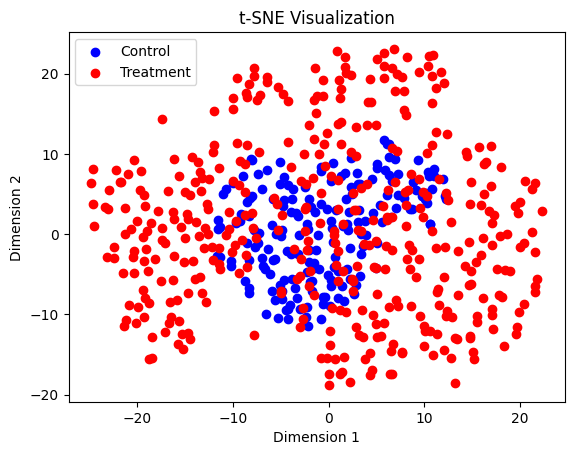

In [137]:
tarnet_model.plot_representation_space()

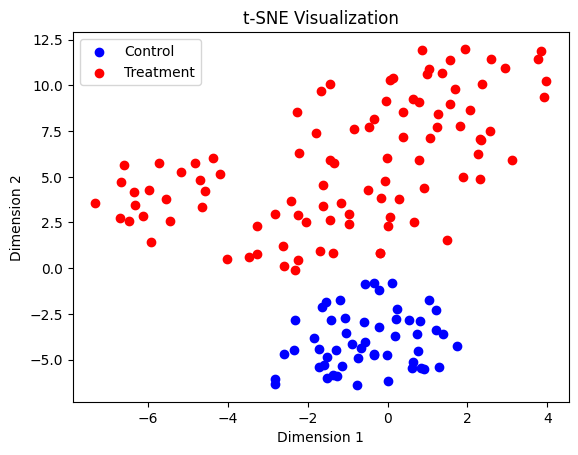

In [160]:
output, X, y, t, ite = tarnet_model.predict_test(use_ite=True)
representation = output[1]
tarnet_model.plot_representation_space(representation, t)

In [161]:
PEHE, ATE, _, _ = tarnet_model.compute_PEHE_ATE_metrics(output[2], output[3], t, ite)
print(np.sqrt(PEHE), ATE)

1.5538282464013116 0.06150197982788086


In [162]:
output, X, y, t, ite = tarnet_model.predict_train(use_ite=True)
representation = output[1]
PEHE, ATE, _, _ = tarnet_model.compute_PEHE_ATE_metrics(output[2], output[3], t, ite)
print(np.sqrt(PEHE), ATE)

1.629025608144813 0.2355022430419922


In [215]:
losses = []
val_losses = []
for alpha in [0,0.0001,0.001,0.01,0.1,1,2,5,6,7,8,10,100]:
    tarnet_model = TARNet(df=IHDP_data, alpha = alpha)
    loss_curve, val_loss_curve = tarnet_model.fit(epochs=10)
    output, X, y, t, ite = tarnet_model.predict_test(use_ite=True)
    representation = output[1]
    #tarnet_model.plot_representation_space(representation, t)
    PEHE_val, ATE_val, _, _ = tarnet_model.compute_PEHE_ATE_metrics(output[2], output[3], t, ite)
    output, X, y, t, ite = tarnet_model.predict_train(use_ite=True)
    representation = output[1]
    PEHE_train, ATE_train, _, _ = tarnet_model.compute_PEHE_ATE_metrics(output[2], output[3], t, ite)
    print(np.sqrt(PEHE), ATE)
    losses.append(pd.DataFrame({'alpha': alpha,
                    'item':range(len(loss_curve)),
                    'curve': loss_curve,
                    'curve_val': val_loss_curve
                    }))
data_loss_curves_by_alpha = pd.concat(losses, ignore_index=True)

u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training
Test set loss: 6.155004024505615
Test set loss: 2.7863714694976807


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.6567292213439941
Test set loss: 1.444069743156433
Test set loss: 1.35111403465271


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.3270419836044312
Test set loss: 1.3154139518737793
Test set loss: 1.323034405708313


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.2953487634658813
Test set loss: 1.321461796760559
done training
0.7210378308999239 0.11936050653457642
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training
Test set loss: 6.00504732131958


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 2.645247220993042
Test set loss: 1.6738425493240356
Test set loss: 1.4531618356704712


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.3712800741195679
Test set loss: 1.3228964805603027
Test set loss: 1.306727647781372


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.298737645149231
Test set loss: 1.3223223686218262
Test set loss: 1.292893648147583
done training
0.7210378308999239 0.11936050653457642
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 5.574468612670898
Test set loss: 2.1865556240081787
Test set loss: 1.344727635383606


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.356195092201233
Test set loss: 1.3303041458129883
Test set loss: 1.3019163608551025


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.3352227210998535
Test set loss: 1.2978324890136719
Test set loss: 1.3262581825256348


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.302923560142517
done training
0.7210378308999239 0.11936050653457642
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training
Test set loss: 6.065164089202881
Test set loss: 2.6827871799468994


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.7021926641464233
Test set loss: 1.4527133703231812
Test set loss: 1.3875890970230103


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.3116605281829834
Test set loss: 1.3281577825546265
Test set loss: 1.3177855014801025


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.3075202703475952
Test set loss: 1.3201395273208618
done training
0.7210378308999239 0.11936050653457642
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training
Test set loss: 5.423362731933594


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 2.2740426063537598
Test set loss: 1.3961119651794434
Test set loss: 1.4297049045562744
Test set loss: 1.3251880407333374


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.3293581008911133
Test set loss: 1.3126769065856934
Test set loss: 1.3491501808166504
Test set loss: 1.3325332403182983


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.3298802375793457
done training
0.7210378308999239 0.11936050653457642
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training
Test set loss: 7.193230628967285
Test set loss: 2.7983641624450684
Test set loss: 1.6517342329025269


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.5415406227111816
Test set loss: 1.3448094129562378
Test set loss: 1.3465981483459473
Test set loss: 1.3410204648971558


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.326128602027893
Test set loss: 1.3054686784744263
Test set loss: 1.3138784170150757
done training
0.7210378308999239 0.11936050653457642
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training
Test set loss: 5.357516288757324


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 2.060082197189331
Test set loss: 1.3856751918792725
Test set loss: 1.3855239152908325
Test set loss: 1.3273075819015503


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.3100568056106567
Test set loss: 1.3418645858764648
Test set loss: 1.3282604217529297
Test set loss: 1.3412163257598877


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.31174898147583
done training
0.7210378308999239 0.11936050653457642
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training
Test set loss: 6.347592353820801
Test set loss: 2.5395851135253906
Test set loss: 1.508913516998291


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.4369324445724487
Test set loss: 1.3214300870895386
Test set loss: 1.310503602027893
Test set loss: 1.339876651763916


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.306033730506897
Test set loss: 1.3095104694366455
Test set loss: 1.3059673309326172
done training
0.7210378308999239 0.11936050653457642
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training
Test set loss: 5.939021587371826


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 2.578199625015259
Test set loss: 1.631147861480713
Test set loss: 1.481423258781433
Test set loss: 1.3214048147201538


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.312140703201294
Test set loss: 1.3544561862945557
Test set loss: 1.3139495849609375
Test set loss: 1.3141114711761475


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.3132212162017822
done training
0.7210378308999239 0.11936050653457642
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training
Test set loss: 7.847517967224121
Test set loss: 3.2624521255493164
Test set loss: 1.6887593269348145


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.4916150569915771
Test set loss: 1.3376998901367188
Test set loss: 1.3006819486618042
Test set loss: 1.3252711296081543


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.2988886833190918
Test set loss: 1.3142240047454834
Test set loss: 1.3091130256652832
done training
0.7210378308999239 0.11936050653457642
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training
Test set loss: 5.413539886474609


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 2.0846774578094482
Test set loss: 1.3988796472549438
Test set loss: 1.3751020431518555
Test set loss: 1.3090075254440308


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.3000973463058472
Test set loss: 1.33940589427948
Test set loss: 1.2939176559448242
Test set loss: 1.3272833824157715


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.3022938966751099
done training
0.7210378308999239 0.11936050653457642
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training
Test set loss: 5.609108924865723
Test set loss: 2.626157760620117
Test set loss: 1.578872799873352


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.5019850730895996
Test set loss: 1.3293523788452148
Test set loss: 1.3460439443588257
Test set loss: 1.3237919807434082


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.396158218383789
Test set loss: 1.3393192291259766
Test set loss: 1.3344097137451172
done training
0.7210378308999239 0.11936050653457642
u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training
Test set loss: 6.173935413360596


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 2.524379253387451
Test set loss: 1.4690076112747192
Test set loss: 1.4097106456756592
Test set loss: 1.3526458740234375


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 1.310604214668274
Test set loss: 1.3230433464050293
Test set loss: 1.3042397499084473
Test set loss: 1.3409228324890137
Test set loss: 1.3197436332702637
done training
0.7210378308999239 0.11936050653457642


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [210]:
data_loss_curves_by_alpha.head()

,alpha,item,curve
0,0.0,0,16.987094
1,0.0,1,3.188901
2,0.0,2,1.572817
3,0.0,3,1.394949
4,0.0,4,1.348908


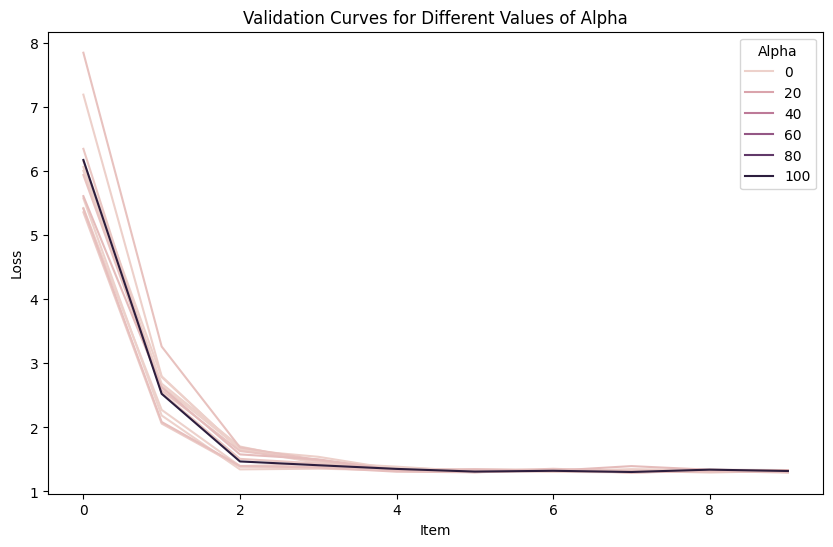

In [217]:
plt.figure(figsize=(10, 6))
#sns.lineplot(data=data_loss_curves_by_alpha,x='item', y='curve', hue='alpha') # data_loss_curves_by_alpha['alpha'].isin([0,1,5,8])
sns.lineplot(data=data_loss_curves_by_alpha,x='item', y='curve_val', hue='alpha')
plt.xlabel("Item")
plt.ylabel("Loss")
plt.title("Validation Curves for Different Values of Alpha")
plt.legend(title="Alpha")
plt.show()

In [200]:
data_loss_curves.head()

,alpha,learning_rate,weight_decay,PEHE_train,PEHE_val,ATE_train,ATE_val,test_pred_loss
0,0.0,0.0001,0.00000,2.891708,2.567605,0.473905,0.264963,1.443585
1,0.0,0.0010,0.00000,2.981058,2.606629,0.618273,0.442915,1.301263
2,0.0,0.0100,0.00000,3.212577,2.791753,0.785990,0.622016,1.274963
3,0.0,0.0001,0.00001,3.066806,2.681851,0.626659,0.425045,1.412304
4,0.0,0.0010,0.00001,3.091058,2.687055,0.699814,0.520870,1.323906


/tmp/ipykernel_212/524223701.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=data,x='alpha', y='PEHE_train', palette='tab10',label='PEHE Train') # data_loss_curves_by_alpha['alpha'].isin([0,1,5,8])
/tmp/ipykernel_212/524223701.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=data,x='alpha', y='PEHE_val', palette='tab10',label='PEHE Val') # data_loss_curves_by_alpha['alpha'].isin([0,1,5,8])
/tmp/ipykernel_212/524223701.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=data,x='alpha', y='ATE_train', palette='tab10',label='ATE Train') # data_loss_curves_by_alpha['alpha'].isin([0,1,5,8])
/tmp/ipykernel_212/524223701.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=data,x='alpha', y='ATE_val', palette='tab10',label='ATE Val') # data_loss_curves_by_alpha['alpha'].isin([0,1,5,

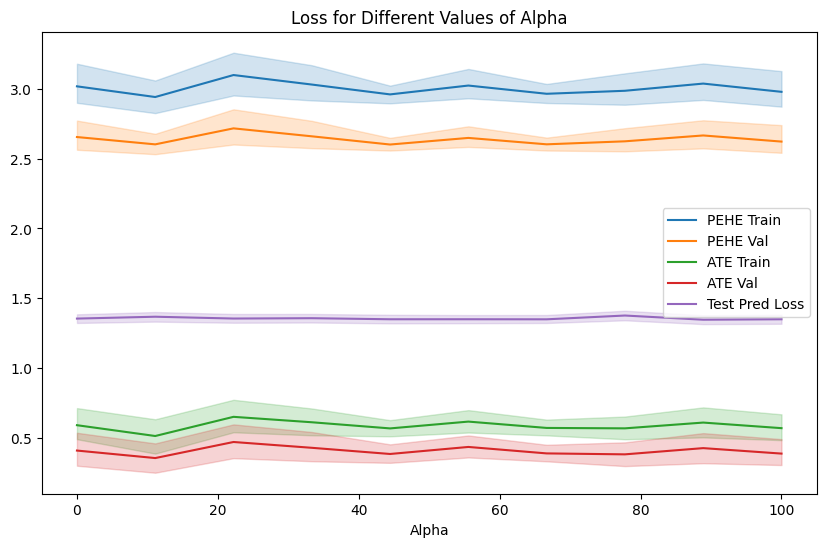

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns

# plt.figure(figsize=(10, 6))
# sns.lineplot(data=data_loss_curves_by_alpha,x='item', y='curve', hue='alpha', palette='tab10') # data_loss_curves_by_alpha['alpha'].isin([0,1,5,8])

# plt.xlabel("Item")
# plt.ylabel("Loss")
# plt.title("Loss Curves for Different Values of Alpha")
# plt.legend(title="Alpha")
# plt.show()

plt.figure(figsize=(10, 6))
data = data_loss_curves#[data_loss_curves_by_alpha['alpha']<101].drop_duplicates(subset = ['alpha','final_loss','PEHE_train','PEHE_val','ATE_train','ATE_val'])
sns.lineplot(data=data,x='alpha', y='PEHE_train', palette='tab10',label='PEHE Train') # data_loss_curves_by_alpha['alpha'].isin([0,1,5,8])
sns.lineplot(data=data,x='alpha', y='PEHE_val', palette='tab10',label='PEHE Val') # data_loss_curves_by_alpha['alpha'].isin([0,1,5,8])

sns.lineplot(data=data,x='alpha', y='ATE_train', palette='tab10',label='ATE Train') # data_loss_curves_by_alpha['alpha'].isin([0,1,5,8])
sns.lineplot(data=data,x='alpha', y='ATE_val', palette='tab10',label='ATE Val') # data_loss_curves_by_alpha['alpha'].isin([0,1,5,8])

sns.lineplot(data=data,x='alpha', y='test_pred_loss', palette='tab10',label='Test Pred Loss') # data_loss_curves_by_alpha['alpha'].isin([0,1,5,8])

plt.legend()
plt.xlabel("Alpha")
plt.ylabel("")
plt.title("Loss for Different Values of Alpha")
plt.show()

In [218]:
# Run on the other data:
IST_data = pd.read_csv('IST_observational.csv')

# Convert to 1/0
IST_data['DALIVE'] = IST_data['DALIVE'].apply(lambda x: 1 if x=='Y' else 0)
IST_data['DASP14'] = IST_data['DASP14'].apply(lambda x: 1 if x=='Y' else 0)
IST_data['DLH14'] = IST_data['DLH14'].apply(lambda x: 1 if x=='Y' else 0)
IST_data['DMH14'] = IST_data['DMH14'].apply(lambda x: 1 if x=='Y' else 0)
IST_data['DHH14'] = IST_data['DHH14'].apply(lambda x: 1 if x=='Y' else 0)

# Treatment variable
IST_data['treatment_asp'] = (IST_data['DASP14'])>0
IST_data['treatment_hep'] = (IST_data['DLH14'] + IST_data['DMH14'] + IST_data['DHH14'])>0
IST_data['treatment'] = IST_data['treatment_asp'] | IST_data['treatment_hep']
IST_data['treatment'] = IST_data['treatment'].apply(lambda x: 1 if x else 0)
IST_data['treatment_asp'] = IST_data['treatment_asp'].apply(lambda x: 1 if x else 0)
IST_data['treatment_hep'] = IST_data['treatment_hep'].apply(lambda x: 1 if x else 0)
IST_data = IST_data.drop(['DASP14', 'DLH14', 'DMH14','DHH14'], axis=1)

# Outcome variable
IST_data['event'] = 1 - IST_data['DALIVE']
IST_data = IST_data.drop(['DALIVE'], axis=1)

IST_data_covariates = IST_data
# Data cleaning
covariates_to_use = ['HOSPNUM', 'AGE','RCONSC','SEX','RSLEEP','RATRIAL','RCT','RVISINF','RHEP24',
                     'RASP3','RSBP','RDEF1','RDEF2','RDEF3','RDEF4','RDEF5','RDEF6','RDEF7','RDEF8',
                     'DAYLOCAL','event','treatment']
X = IST_data_covariates[covariates_to_use]
X['AGE'] = (X['AGE'] - X['AGE'].mean()) / X['AGE'].std()
X['RSBP'] = (X['RSBP'] - X['RSBP'].mean()) / X['RSBP'].std()
X = pd.get_dummies(X, columns=['RCONSC'], prefix='RCONSC')
X = pd.get_dummies(X, columns=['SEX'], prefix='SEX')
X = pd.get_dummies(X, columns=['RSLEEP'], prefix='RSLEEP')
X = pd.get_dummies(X, columns=['RDEF1'], prefix='RDEF1')
X = pd.get_dummies(X, columns=['RDEF2'], prefix='RDEF2')
X = pd.get_dummies(X, columns=['RDEF3'], prefix='RDEF3')
X = pd.get_dummies(X, columns=['RDEF4'], prefix='RDEF4')
X = pd.get_dummies(X, columns=['RDEF5'], prefix='RDEF5')
X = pd.get_dummies(X, columns=['RDEF6'], prefix='RDEF6')
X = pd.get_dummies(X, columns=['RDEF7'], prefix='RDEF7')
X = pd.get_dummies(X, columns=['RDEF8'], prefix='RDEF8')
X = pd.get_dummies(X, columns=['RVISINF'], prefix='RVISINF')
X = pd.get_dummies(X, columns=['RHEP24'], prefix='RHEP24')
X = pd.get_dummies(X, columns=['RASP3'], prefix='RASP3')
X = pd.get_dummies(X, columns=['RATRIAL'], prefix='RATRIAL')
X = pd.get_dummies(X, columns=['RCT'], prefix='RCT')
X = pd.get_dummies(X, columns=['DAYLOCAL'], prefix='DAYLOCAL')
covariate_cols = ['HOSPNUM', 'AGE', 'RSBP', 'event', 'RCONSC_D', 'RCONSC_F', 'RCONSC_U',
       'SEX_F', 'SEX_M', 'RSLEEP_N', 'RSLEEP_Y', 'RDEF1_C', 'RDEF1_N',
       'RDEF1_Y', 'RDEF2_C', 'RDEF2_N', 'RDEF2_Y', 'RDEF3_C', 'RDEF3_N',
       'RDEF3_Y', 'RDEF4_C', 'RDEF4_N', 'RDEF4_Y', 'RDEF5_C', 'RDEF5_N',
       'RDEF5_Y', 'RDEF6_C', 'RDEF6_N', 'RDEF6_Y', 'RDEF7_C', 'RDEF7_N',
       'RDEF7_Y', 'RDEF8_C', 'RDEF8_N', 'RDEF8_Y', 'RVISINF_N', 'RVISINF_Y',
       'RHEP24_N', 'RHEP24_Y', 'RASP3_N', 'RASP3_Y', 'RATRIAL_N', 'RATRIAL_Y',
       'RCT_N', 'RCT_Y', 'DAYLOCAL_1', 'DAYLOCAL_2', 'DAYLOCAL_3',
       'DAYLOCAL_4', 'DAYLOCAL_5', 'DAYLOCAL_6', 'DAYLOCAL_7']

tarnet_model = TARNet(df=X,covariate_cols=covariate_cols,treatment_col='treatment',label_col='event', alpha = 0)
tarnet_model.fit(epochs=10)
output, X, y, t, _ = tarnet_model.predict_test()
PEHE, ATE, _, ATE_pred= tarnet_model.compute_PEHE_ATE_metrics(output[2], output[3], t)
print(np.sqrt(PEHE), ATE, ATE_pred)
# cfr_model = TARNet(df=X,covariate_cols=covariate_cols,treatment_col='treatment',label_col='event', alpha = 1)
# cfr_model.fit(epochs=10)
# output, X, y, t, _ = cfr_model.predict_test()
# PEHE, ATE, _, ATE_pred= cfr_model.compute_PEHE_ATE_metrics(output[2], output[3], t)
# print(np.sqrt(PEHE), ATE, ATE_pred)

/tmp/ipykernel_212/1916191653.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['AGE'] = (X['AGE'] - X['AGE'].mean()) / X['AGE'].std()
/tmp/ipykernel_212/1916191653.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['RSBP'] = (X['RSBP'] - X['RSBP'].mean()) / X['RSBP'].std()
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect resu

u: 0.6237208081868276
cpu
data:
data shapes: torch.Size([3811, 52]), torch.Size([3811]), torch.Size([3811])
starting training


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 35])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([953])) that is different to the input size (torch.Size([953, 953])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 0.26946133375167847


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 35])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([953])) that is different to the input size (torch.Size([953, 953])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 0.25808343291282654


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 35])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([953])) that is different to the input size (torch.Size([953, 953])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 0.2878308892250061


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 35])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([953])) that is different to the input size (torch.Size([953, 953])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 0.2592775523662567


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 35])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([953])) that is different to the input size (torch.Size([953, 953])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 0.26028844714164734


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 35])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([953])) that is different to the input size (torch.Size([953, 953])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 0.25396624207496643


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 35])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([953])) that is different to the input size (torch.Size([953, 953])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 0.2570561170578003


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 35])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([953])) that is different to the input size (torch.Size([953, 953])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 0.2519339323043823


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 35])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([953])) that is different to the input size (torch.Size([953, 953])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Test set loss: 0.2520916759967804
Test set loss: 0.2517569363117218
done training
0.7316135269091874 0.17204049229621887 tensor(-0.0640)


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 35])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([953])) that is different to the input size (torch.Size([953, 953])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### 2.4 NeurIPS Reviewer for a Day: Reviewing & Reproducing Recent Research on ML-Based Causal Inference

In [222]:
class Dragonnet(nn.Module):
    def __init__(self, df, covariate_cols=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10',
                                           'X11','X12','X13','X14','X15','X16','X17','X18','X19','X20',
                                           'X21','X22','X23','X24','X25'],
                                           treatment_col='T', label_col='Y',ite_label='ITE', target_reg=False,
                                           lr=0.001, alpha=1, beta = 1, weight_decay=0): 
        # default alpha and beta from paper directly
        # epsilon is learned
        super(Dragonnet, self).__init__() 
        
        # Data parameters
        self.df = df
        self.covariate_cols = covariate_cols
        self.treatment_col = treatment_col
        self.label_col = label_col
        self.ite_label = ite_label
        self.lr = lr
        self.df, self.test_df = train_test_split(self.df, test_size=0.2, random_state=42)
        
        # Loss hyperparameters
        self.target_reg = target_reg
        self.alpha = alpha
        self.epsilon=nn.Parameter(torch.tensor(1.0))
        self.beta = beta
        self.weight_decay = weight_decay
        
        self.u = max(1e-6, min(1 - 1e-6, sum(self.df[self.treatment_col].values) / len(self.df[self.treatment_col].values)))
        print(f'u: {self.u}')
        self.input_dim = len(covariate_cols)
        self.output_dim = 1 # for each arm we predict a single value, Y_hat
        self.hidden_dim = 200
        
        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)
        self.to(self.device)

        # Layers:
        # "CFR is implemented as a feed-forward
        # neural network with 3 fully-connected exponential-linear
        # layers for the representation and 3 for the hypothesis. Layer
        # sizes were 200 for all layers used for Jobs and 200 and 100
        # for the representation and hypothesis used for IHDP.""
        
        self.representation_layers = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim), 
            nn.ELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim), 
            nn.ELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim), 
            nn.ELU(),
        )
        self.control_arm = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim), 
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim), 
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim)
        )
        self.propensity_arm = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim), 
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim), 
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim),
            nn.Sigmoid()
            
        )
        self.treatment_arm = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim), 
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim), 
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim)
            
        )
        # The model is trained using Adam's (Kingma & Ba, 2014). 
        self.optimizer = optim.Adam(
                               list(self.representation_layers.parameters())+
                               list(self.control_arm.parameters())+
                               list(self.propensity_arm.parameters())+
                               list(self.treatment_arm.parameters())+
                               [self.epsilon], lr=self.lr, weight_decay=self.weight_decay)
        # optimizer_representation = optim.Adam(list(self.representation_layers.parameters()), lr=lr)
        # optimizer_control = optim.Adam(list(self.control_arm.parameters()), lr=lr)
        # optimizer_treatment = optim.Adam(list(self.treatment_arm.parameters()), lr=lr)
    
        
        
        # For continuous data we use mean squared loss and for binary data, we'd use log-loss.
        self.prediction_loss = nn.MSELoss()
        self.propensity_loss = nn.BCELoss()

        

        # Ignore regularization for now
        # self.regularizing_term = self.lambda_ * torch.norm(self.weights, p=2) 
        
        # loss = self.hypothesis_loss + self.regularizing_term + self.IPM_penalty_loss

    def forward(self, X, t):

        representation = self.representation_layers(X)
        control_out = self.control_arm(representation)
        treatment_out = self.treatment_arm(representation)
        propensity = self.propensity_arm(representation)
        y_pred = t * treatment_out + (1 - t) * control_out
        
        return y_pred, representation, control_out, treatment_out, propensity
        
    def fit(self, epochs=10, batch_size=64):
        # Set to training mode
        self.representation_layers.train()
        self.treatment_arm.train()
        self.control_arm.train()
        self.propensity_arm.train()

        # Get data
        losses = []
        print('data:')
        
        X = torch.tensor(self.df[self.covariate_cols].astype(float).values, dtype=torch.float32)
        y = torch.tensor(self.df[self.label_col].values, dtype=torch.float32)
        t = torch.tensor(self.df[self.treatment_col].values, dtype=torch.float32)
        X = X.to(self.device)
        y = y.to(self.device)
        t = t.to(self.device)
        
        print(f'data shapes: {X.shape}, {y.shape}, {t.shape}')
        
        print('starting training')
        for epoch in range(epochs):
            epoch_losses = []
            print(epoch)

            # Shuffle data
            indices = torch.randperm(len(X))
            X = X[indices]
            y = y[indices]
            t = t[indices]

            batch_size = 64
            # Batch data
            for i in range(0, len(X), batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                t_batch = t[i:i + batch_size]

                try:
                    # Zero gradients
                    self.optimizer.zero_grad()
                    # optimizer_representation.zero_grad()
                    # optimizer_control.zero_grad()
                    # optimizer_treatment.zero_grad()

                    y_pred, representation, _, _, propensity = self.forward(X_batch, t_batch)
                except Exception as e:
                    print(e)
                    print('error')

                # Calculate weights
                weights = (t_batch / (2 * self.u)) + ((1 - t_batch) / (2 * (1 - self.u)))
                # print(weights)
                
                # Calculate prediction loss
                loss = torch.mean(weights * self.prediction_loss(y_pred, y_batch))
                #print(f'loss_prediction: {loss}')
                
                # control_condition = (t_batch==0)
                
                # representation_control = representation[control_condition]
                # representation_treatment = representation[~control_condition]

                #loss_pred = loss_y0 + loss_y1  # Prediction loss

                # Propensity loss
                print(propensity.shape)
                loss_propensity = self.alpha * self.propensity_loss(propensity.squeeze(), t_batch)
                loss += loss_propensity

                if self.target_reg:
                    target = y_batch - y_pred + self.epsilon*(t_batch/ propensity.squeeze() + (1-t_batch)/(1-propensity.squeeze()))
                    loss_target = self.beta * torch.mean(target)
                    loss+= loss_target
                
                #loss_total = loss_pred + loss_ipm
                # Backpropagate both prediction loss (through all layers) and IPM loss (through representation layers)
                loss.backward()  # Prediction loss affects all layers
                
                # optimizer_representation.step()  # Update representation layers (affects both prediction and MMD)
                # optimizer_control.step()  # Update control prediction head
                # optimizer_treatment.step()  # Update treatment prediction head
                self.optimizer.step()
                epoch_losses.append(loss.item())
            
            avg_loss = sum(epoch_losses) / len(epoch_losses)
            
            losses.append(avg_loss)

            if epoch % 10 == 0:
                print(f'Epoch: {epoch}, Loss: {loss.item()}')
        print('done training')
        return losses
        
            
    def predict_train(self, use_ite=False):
        X = torch.tensor(self.df[self.covariate_cols].astype(float).values, dtype=torch.float32)
        y = torch.tensor(self.df[self.label_col].values, dtype=torch.float32)
        t = torch.tensor(self.df[self.treatment_col].values, dtype=torch.float32)
        X = X.to(self.device)
        y = y.to(self.device)
        t = t.to(self.device)
        if use_ite:
            ite = torch.tensor(self.df[self.ite_label].astype(float).values, dtype=torch.float32)
        else:
            ite = None
        self.eval()  # Set model to evaluation mode
        with torch.no_grad():  # No gradients needed for prediction
            return self.forward(X,t), X, y, t, ite
    
    def predict_test(self, use_ite=False):
        X = torch.tensor(self.test_df[self.covariate_cols].astype(float).values, dtype=torch.float32)
        y = torch.tensor(self.test_df[self.label_col].values, dtype=torch.float32)
        t = torch.tensor(self.test_df[self.treatment_col].values, dtype=torch.float32)
        X = X.to(self.device)
        y = y.to(self.device)
        t = t.to(self.device)
        if use_ite:
            ite = torch.tensor(self.test_df[self.ite_label].astype(float).values, dtype=torch.float32)
        else:
            ite = None
        self.eval()  # Set model to evaluation mode
        with torch.no_grad():  # No gradients needed for prediction
            return self.forward(X,t), X, y, t, ite
    
    # plot the t-sne
    def plot_representation_space(self, representation=None, t=None, n_components=2):
        """Plot the representation space"""
        
        if representation is None:
            representation = torch.tensor(self.df[self.covariate_cols].astype(float).values, dtype=torch.float32)
            t = torch.tensor(self.df[self.treatment_col].values, dtype=torch.float32)
        # Index on what is control versus treatment
        representation_control = representation[t == 0]
        representation_treatment = representation[t == 1]

        # Run separate t-SNE on control and treatment representations
        tsne_control = TSNE(n_components=n_components, random_state=42)
        X_tsne_control = tsne_control.fit_transform(representation_control.detach().numpy())
        
        tsne_treatment = TSNE(n_components=n_components, random_state=42)
        X_tsne_treatment = tsne_treatment.fit_transform(representation_treatment.detach().numpy())

        # Plot t-SNE
        plt.scatter(X_tsne_control[:, 0], X_tsne_control[:, 1], color='blue', label='Control')
        plt.scatter(X_tsne_treatment[:, 0], X_tsne_treatment[:, 1], color='red', label='Treatment')
        plt.title("t-SNE Visualization")
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.legend()
        plt.show()
    
    def compute_PEHE_ATE_metrics(self, control_output, treatment_output, t, ite=None):
        """Compute comparison metrics"""
        ite_pred = treatment_output - control_output 
        if ite is not None:
            ite_true = ite 
        else:
            ite_true = torch.where(t == 1, y, -y)
        #print(ite_pred, ite_true)
        pehe = torch.mean((ite_pred - ite_true) ** 2)
        #print(pehe)
    
        ate_pred = torch.mean(ite_pred)  
        ate_true = torch.mean(ite_true)  
        ate_error = torch.abs(ate_pred - ate_true)
        
        return pehe.item(), ate_error.item(), ite_pred, ate_pred 

In [228]:
# dragonnet grid search

from itertools import product
 
weight_decay_values = [0, 1e-5, 1e-4, 1e-3, 1e-2] 
learning_rate_values = [1e-4, 1e-3, 1e-2]  

losses = []

# Perform grid search
for weight_decay, learning_rate in product(weight_decay_values, learning_rate_values):
    dragonnet = Dragonnet(df=IHDP_data, lr=learning_rate, weight_decay=weight_decay, target_reg=True)  

    # Train model
    dragonnet.fit(epochs=10)

    # Evaluate on validation set
    output, X, y, t, ite = dragonnet.predict_test(use_ite=True)
    PEHE_val, ATE_val, _, _ = dragonnet.compute_PEHE_ATE_metrics(output[2], output[3], t, ite)

    # Evaluate on training set
    output, X, y, t, ite = dragonnet.predict_train(use_ite=True)
    PEHE_train, ATE_train, _, _ = dragonnet.compute_PEHE_ATE_metrics(output[2], output[3], t, ite)

    # print(f"Alpha: {alpha}, LR: {learning_rate}, WD: {weight_decay}, PEHE: {np.sqrt(PEHE_val)}, ATE: {ATE_val}, test loss {test_loss}")

    losses.append(pd.DataFrame({
        'learning_rate': [learning_rate],
        'weight_decay': [weight_decay],
        'PEHE_train': [PEHE_train],
        'PEHE_val': [PEHE_val],
        'ATE_train': [ATE_train],
        'ATE_val': [ATE_val]
    }))


data_loss_curves = pd.concat(losses, ignore_index=True)

u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training
0
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 40.99491882324219
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 27.33403968811035
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 32.63753128051758
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1]

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 35.324920654296875
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 44.85654067993164
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1]

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([21, 1])
Epoch: 0, Loss: 30.456602096557617
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 42.52046203613281
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([21, 1])
Epoch: 0, Loss: 32.190120697021484
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 34.50538635253906
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([21, 1])
Epoch: 0, Loss: 28.535511016845703
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

In [229]:
# target_reg
data_loss_curves.sort_values(by='ATE_val', ascending=True) 

,learning_rate,weight_decay,PEHE_train,PEHE_val,ATE_train,ATE_val
14,0.0100,0.01000,2.748847,2.553946,0.106567,0.037287
8,0.0100,0.00010,2.786715,2.553660,0.295499,0.082283
5,0.0100,0.00001,2.735129,2.487037,0.302767,0.150809
7,0.0010,0.00010,2.662169,2.612303,0.022047,0.295017
1,0.0010,0.00000,2.641895,2.589763,0.000568,0.321918
11,0.0100,0.00100,2.940913,2.584604,0.565357,0.377377
4,0.0010,0.00001,2.664600,2.648667,0.064270,0.379113
10,0.0010,0.00100,2.678971,2.656550,0.108154,0.389064
2,0.0100,0.00000,3.072323,2.690761,0.641393,0.469834
13,0.0010,0.01000,2.873941,2.957601,0.464016,0.680925


In [224]:
# not target reg
data_loss_curves.sort_values(by='ATE_val', ascending=True) 

,learning_rate,weight_decay,PEHE_train,PEHE_val,ATE_train,ATE_val
13,0.0010,0.01000,2.691592,2.482581,0.178858,0.037118
11,0.0100,0.00100,2.737004,2.476910,0.338932,0.179798
10,0.0010,0.00100,2.645748,2.507511,0.052837,0.208738
7,0.0010,0.00010,2.663659,2.544196,0.055027,0.211157
14,0.0100,0.01000,2.813295,2.546569,0.358686,0.213195
4,0.0010,0.00001,2.662688,2.549766,0.070423,0.221489
1,0.0010,0.00000,2.691850,2.595268,0.016544,0.258100
5,0.0100,0.00001,3.013364,2.635822,0.613148,0.432428
8,0.0100,0.00010,3.054376,2.685264,0.665096,0.509448
2,0.0100,0.00000,3.344254,2.884808,0.742758,0.546526


In [234]:
# Dragonnet \pm target_reg results
losses = []

for alpha in range(0,100):
    dragon_model = Dragonnet(df=IHDP_data,lr=0.001, weight_decay=0.001,target_reg=True)
    loss_curve = dragon_model.fit(epochs=10)
    output, X, y, t, ite = dragon_model.predict_test(use_ite=True)
    representation = output[1]
    #tarnet_model.plot_representation_space(representation, t)
    PEHE_val, ATE_val, _, _ = dragon_model.compute_PEHE_ATE_metrics(output[2], output[3], t, ite)
    output, X, y, t, ite = dragon_model.predict_train(use_ite=True)
    representation = output[1]
    PEHE_train, ATE_train, _, _ = dragon_model.compute_PEHE_ATE_metrics(output[2], output[3], t, ite)
    print(np.sqrt(PEHE_val), ATE_val)
    losses.append(pd.DataFrame({'index': [alpha],
                    #'item':range(len(loss_curve)),
                    #'curve': loss_curve,
                    #'final_loss': loss_curve[-1],
                    'PEHE_train': [PEHE_train],
                    'PEHE_val': [PEHE_val],
                    'ATE_train': [ATE_train],
                    'ATE_val': [ATE_val]}))
data_loss_curves_by_alpha = pd.concat(losses, ignore_index=True)


u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training
0
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 33.654624938964844
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
7
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
7
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
7
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 29.900293350219727
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Loss: 33.67662048339844
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
7
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 26.618911743164062
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
7
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 32.49427032470703
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 26.542821884155273
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([21, 1])
Epoch: 0, Loss: 25.039670944213867
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
7
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 29.2912540435791
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 31.85556411743164
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 28.2862548828125
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 29.89826202392578
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([21, 1])
Epoch: 0, Loss: 32.186790466308594
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 28.94973373413086
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1]

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 31.392269134521484
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 34.09165573120117
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1]

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 30.235164642333984
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 35.35589599609375
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 29.916587829589844
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([21, 1])
Epoch: 0, Loss: 25.117374420166016
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 27.284852981567383
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 26.79305076599121
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
7
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 24.896835327148438
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 29.64905548095703
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1]

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 22.779685974121094
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 32.696353912353516
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 25.37253189086914
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
7
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 28.72996711730957
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 33.494808197021484
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([21, 1])
Epoch: 0, Loss: 33.018638610839844
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 26.166385650634766
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 32.32076644897461
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 28.205692291259766
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 35.85493087768555
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 28.332490921020508
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([21, 1])
Epoch: 0, Loss: 26.054012298583984
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64,

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 31.263452529907227
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 27.71184539794922
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 28.05575180053711
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 26.60041046142578
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1]

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 34.13821792602539
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 31.485843658447266
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 31.45623016357422
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 29.851482391357422
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 29.9691104888916
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 33.06924057006836
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 

/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 29.01963996887207
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1]

In [236]:
print('PEHE train:')
print(data_loss_curves_by_alpha['PEHE_train'].mean(), data_loss_curves_by_alpha['PEHE_train'].std()/10)

print('PEHE val:')
print(data_loss_curves_by_alpha['PEHE_val'].mean(), data_loss_curves_by_alpha['PEHE_val'].std()/10)


print('ATE train:')
print(data_loss_curves_by_alpha['ATE_train'].mean(), data_loss_curves_by_alpha['ATE_train'].std()/10)

print('ATE val:')
print(data_loss_curves_by_alpha['ATE_val'].mean(), data_loss_curves_by_alpha['ATE_val'].std()/10)

# # Dragonnet
# PEHE train:
# 2.6851692366600037 0.004922063091041307
# PEHE val:
# 2.526539189815521 0.005687062305165922
# ATE train:
# 0.1289555287361145 0.008504041445361255
# ATE val:
# 0.15762019872665406 0.009567426961130061

# targeted reg  lr=0.01, weight_decay=0.01
# PEHE train:
# 3.348403968811035 0.041312828859681724
# PEHE val:
# 2.9457097482681274 0.03138265938218834
# ATE train:
# 0.6878573417663574 0.026678254831769627
# ATE val:
# 0.5086178970336914 0.02602220537772217

# PEHE train: lr=0.001, weight_decay=0.01
# 2.6921644949913026 0.004846111401487302
# PEHE val:
# 2.612568447589874 0.009969611789811216
# ATE train:
# 0.10850232124328613 0.007548813325763119
# ATE val:
# 0.2810556554794312 0.013563754069221987

# PEHE train: lr=0.001, weight_decay=0.001,target_reg=True)
# 2.6805123901367187 0.0035316549048086945
# PEHE val:
# 2.5747467422485353 0.006824631164962641
# ATE train:
# 0.10230266809463501 0.006469843239704169
# ATE val:
# 0.22802986860275268 0.01191052115048386
# Dragonnet



PEHE train:
2.6805123901367187 0.0035316549048086945
PEHE val:
2.5747467422485353 0.006824631164962641
ATE train:
0.10230266809463501 0.006469843239704169
ATE val:
0.22802986860275268 0.01191052115048386


In [97]:
dragon_model = Dragonnet(df=IHDP_data,lr=0.0001, weight_decay=0.00001,target_reg=False)
dragon_model.fit(epochs=10)
output, X, y, t, ite = dragon_model.predict_train(use_ite=True)
PEHE, ATE, _, _ = dragon_model.compute_PEHE_ATE_metrics(output[2], output[3], t, ite)
print('Training:')
print(np.sqrt(PEHE), ATE)
output, X, y, t, ite = dragon_model.predict_test(use_ite=True)
PEHE, ATE, _, _ = dragon_model.compute_PEHE_ATE_metrics(output[2], output[3], t, ite)
print('Test:')
print(np.sqrt(PEHE), ATE)

u: 0.6884422110552764
cpu
data:
data shapes: torch.Size([597, 25]), torch.Size([597]), torch.Size([597])
starting training
0
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
Epoch: 0, Loss: 21.587852478027344
1
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
2
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])


/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/venv/default/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
3
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
4
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
5
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
6
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([21, 1])
7
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size